In [4]:
import pandas as pd
#Load the dataset 
file_path = r"C:\Users\punee\Downloads\Aditi coding\RFLFSODataFull.csv"
data = pd.read_csv(file_path)

In [6]:
# Separate dataset based on "RFL_Att" and "FSO_Att"
rfl_data = data.drop(columns=['FSO_Att'])  # Drop FSO columns for RFL dataset
fso_data = data.drop(columns=['RFL_Att'])  # Drop RFL columns for FSO dataset

# Display the structure of the split datasets
print("RFL Dataset:")
print(rfl_data.head())

print("\nFSO Dataset:")
print(fso_data.head())


RFL Dataset:
    RFL_Att  AbsoluteHumidity  AbsoluteHumidityMax  AbsoluteHumidityMin  \
0  6.927868         17.595709            17.615907            17.340148   
1  4.412096         17.549693            17.572415            17.299439   
2  6.268740         17.290230            17.644014            16.037894   
3  4.317853         16.820880            17.066776            15.895622   
4  6.114514         16.813820            17.953974            15.227225   

      Distance    Frequency  Particulate  ParticulateMax  ParticulateMin  \
0  2115.338398  83500000000          0.0             0.0             0.0   
1  2113.999257  73500000000          0.0             0.0             0.0   
2  2118.689047  83500000000          0.0             0.0             0.0   
3  2114.632339  73500000000          0.0             0.0             0.0   
4  2116.786055  83500000000          0.0             0.0             0.0   

   RainIntensity  ...  TemperatureMax  TemperatureMin  Time   Visibility  \
0  

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_random_forest(data, target_column):
    # Exclude target column
    features = data.drop(columns=[target_column]).columns
    target = data[target_column]
    
    results = []  # To store RMSE and R^2 for each iteration

    # Iterate through all features and train Random Forest
    for feature_to_remove in features:
        print(f"Evaluating without feature: {feature_to_remove}")
        
        # Prepare data by excluding the selected feature
        X = data.drop(columns=[target_column, feature_to_remove])
        y = target

        # Train Random Forest
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
        rf_model.fit(X, y)

        # Out-of-Bag Predictions
        oob_predictions = rf_model.oob_prediction_

        # Calculate RMSE and R^2
        rmse = np.sqrt(mean_squared_error(y, oob_predictions))
        r2 = r2_score(y, oob_predictions)

        # Append results
        results.append({'Feature Removed': feature_to_remove, 'RMSE': rmse, 'R^2': r2})

    return pd.DataFrame(results)

# Perform evaluation on RFL and FSO subsets
rfl_results = evaluate_random_forest(rfl_data, 'RFL_Att')
fso_results = evaluate_random_forest(fso_data, 'FSO_Att')

# Display the results
print("RFL Results:")
print(rfl_results)

print("\nFSO Results:")
print(fso_results)


Evaluating without feature: AbsoluteHumidity
Evaluating without feature: AbsoluteHumidityMax
Evaluating without feature: AbsoluteHumidityMin
Evaluating without feature: Distance
Evaluating without feature: Frequency
Evaluating without feature: Particulate
Evaluating without feature: ParticulateMax
Evaluating without feature: ParticulateMin
Evaluating without feature: RainIntensity
Evaluating without feature: RainIntensityMax
Evaluating without feature: RainIntensityMin
Evaluating without feature: RelativeHumidity
Evaluating without feature: SYNOPCode
Evaluating without feature: Temperature
Evaluating without feature: TemperatureDifference
Evaluating without feature: TemperatureMax
Evaluating without feature: TemperatureMin
Evaluating without feature: Time
Evaluating without feature: Visibility
Evaluating without feature: VisibilityMax
Evaluating without feature: VisibilityMin
Evaluating without feature: WindDirection
Evaluating without feature: WindSpeed
Evaluating without feature: Win

In [10]:
def evaluate_on_test_data(train_data, test_data, target_column):
    # Train Random Forest on full features
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]

    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on test data
    predictions = rf_model.predict(X_test)

    # Calculate RMSE and R^2
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    return rmse, r2




In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def iterative_feature_removal(data, target_column):
    """
    Iteratively remove features based on their importance and calculate RMSE & R^2.
    """
    # Initial list of features
    features = list(data.drop(columns=[target_column]).columns)
    remaining_features = features.copy()
    
    results = []

    while len(remaining_features) > 0:
        print(f"Remaining features: {remaining_features}")
        
        # Prepare data
        X = data[remaining_features]
        y = data[target_column]

        # Train Random Forest
        model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
        model.fit(X, y)

        # Out-of-Bag predictions
        oob_predictions = model.oob_prediction_
        oob_rmse = np.sqrt(mean_squared_error(y, oob_predictions))
        oob_r2 = r2_score(y, oob_predictions)

        # Rank features by importance
        importances = model.feature_importances_
        least_important_feature = remaining_features[np.argmin(importances)]

        # Record the results
        results.append({
            'Remaining Features': remaining_features.copy(),
            'Removed Feature': least_important_feature,
            'OOB RMSE': oob_rmse,
            'OOB R^2': oob_r2
        })

        # Remove the least important feature
        remaining_features.remove(least_important_feature)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Apply the algorithm to RFL and FSO subsets
rfl_results = iterative_feature_removal(rfl_data, target_column='RFL_Att')
fso_results = iterative_feature_removal(fso_data, target_column='FSO_Att')

# Save results for visualization
print("RFL Feature Importance Results:")
print(rfl_results)

print("\nFSO Feature Importance Results:")
print(fso_results)


Remaining features: ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection', 'WindSpeed', 'WindSpeedMax', 'WindSpeedMin']
Remaining features: ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindSpeed', 'WindSpeedMax', 'WindSpeedMin']
Remaining features: ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulat

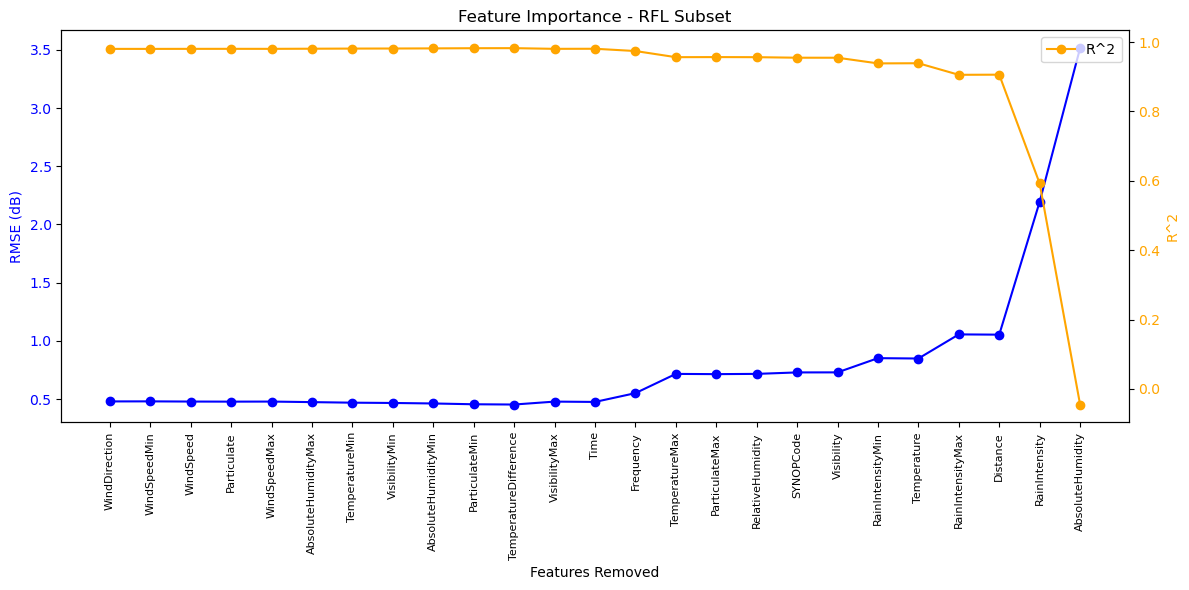

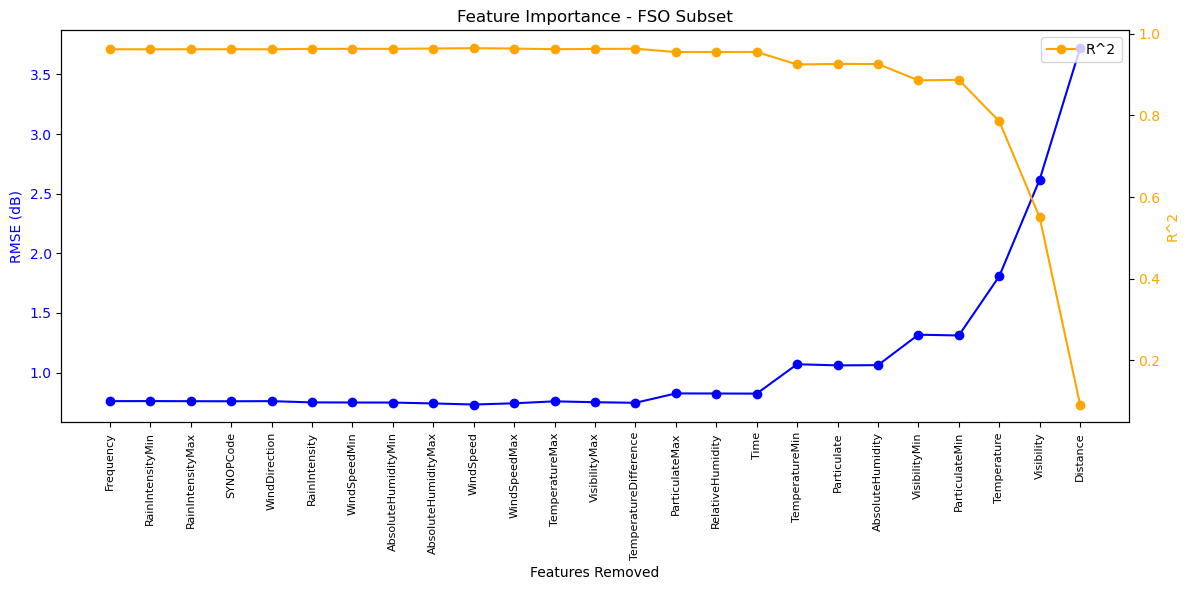

In [16]:
def plot_feature_removal_results(results_df, title):
    """
    Plot RMSE and R^2 values at each step of feature removal.
    """
    features_removed = range(len(results_df))
    rmse_values = results_df['OOB RMSE']
    r2_values = results_df['OOB R^2']
    removed_features = results_df['Removed Feature']

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot RMSE
    ax1.plot(features_removed, rmse_values, color='blue', marker='o', label='RMSE')
    ax1.set_xlabel('Features Removed')
    ax1.set_ylabel('RMSE (dB)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Plot R^2
    ax2 = ax1.twinx()
    ax2.plot(features_removed, r2_values, color='orange', marker='o', label='R^2')
    ax2.set_ylabel('R^2', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add feature names on x-axis
    ax1.set_xticks(features_removed)
    ax1.set_xticklabels(removed_features, rotation=90, fontsize=8)

    plt.title(title)
    fig.tight_layout()
    plt.legend(loc='upper right')
    plt.show()

# Plot results for RFL and FSO
plot_feature_removal_results(rfl_results, "Feature Importance - RFL Subset")
plot_feature_removal_results(fso_results, "Feature Importance - FSO Subset")


In [ ]:


def cap_outliers(data, columns, threshold=3):
    
    for column in columns:
        if column in data.columns:  # Ensure column exists in the dataset
            z_scores = (data[column] - data[column].mean()) / data[column].std()
            data[column] = np.where(
                z_scores > threshold, data[column].mean() + threshold * data[column].std(), data[column]
            )
            data[column] = np.where(
                z_scores < -threshold, data[column].mean() - threshold * data[column].std(), data[column]
            )
    return data

# Apply outlier handling only for columns in the respective datasets
print("Handling outliers for RFL data...")
rfl_data = cap_outliers(rfl_data, ['RFL_Att'])  # Only handle 'RFL_Att' in rfl_data
print("Handling outliers for FSO data...")
fso_data = cap_outliers(fso_data, ['FSO_Att'])  # Only handle 'FSO_Att' in fso_data

# Cross-validation and evaluation function
def calculate_synop_metrics_with_cv(data, synop_column, target_column, selected_features):
    
    synop_codes = data[synop_column].unique()
    overall_results = []

    for synop in synop_codes:
        print(f"Evaluating with SYNOP code {synop} as testing data.")

        # Split the data
        train_data = data[data[synop_column] != synop]  # All other SYNOP codes as training
        test_data = data[data[synop_column] == synop]  # Current SYNOP code as testing

        # Prepare training and testing sets
        X_train = train_data[selected_features]
        y_train = train_data[target_column]
        X_test = test_data[selected_features]
        y_test = test_data[target_column]

        # Train the model and cross-validate
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cross_val_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv)

        # Train on full training set and predict
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)

        # Append the results
        overall_results.append({
            'SYNOP Code': synop,
            'Cross-Validated R² Mean': np.mean(cross_val_scores),
            'RMSE': rmse,
            'R²': r2
        })

    # Calculate metrics for the whole dataset
    print("\nEvaluating on the entire dataset.")
    X = data[selected_features]
    y = data[target_column]
    model.fit(X, y)
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    overall_results.append({
        'SYNOP Code': 'Overall',
        'Cross-Validated R² Mean': None,  # Not applicable for the entire dataset
        'RMSE': rmse,
        'R²': r2
    })

    # Convert results to DataFrame
    results_df = pd.DataFrame(overall_results)
    return results_df

# Specify the SYNOP code column
synop_column = 'SYNOPCode'  # Replace with the actual column name for SYNOP codes

# Ensure final features are extracted correctly
final_rfl_features = rfl_results.iloc[-1]['Remaining Features']
final_fso_features = fso_results.iloc[-1]['Remaining Features']

# Calculate SYNOP metrics for RFL
rfl_synop_results = calculate_synop_metrics_with_cv(rfl_data, synop_column, 'RFL_Att', final_rfl_features)
print("\nRFL SYNOP-wise Metrics with Cross-Validation:")
print(rfl_synop_results)

# Calculate SYNOP metrics for FSO
fso_synop_results = calculate_synop_metrics_with_cv(fso_data, synop_column, 'FSO_Att', final_fso_features)
print("\nFSO SYNOP-wise Metrics with Cross-Validation:")
print(fso_synop_results)

# Save results to CSV for review
rfl_synop_results.to_csv("RFL_SYNOP_wise_Metrics_CV.csv", index=False)
fso_synop_results.to_csv("FSO_SYNOP_wise_Metrics_CV.csv", index=False)
print("\nMetrics saved to 'RFL_SYNOP_wise_Metrics_CV.csv' and 'FSO_SYNOP_wise_Metrics_CV.csv'")
